# Loading and Prepping the odometry data

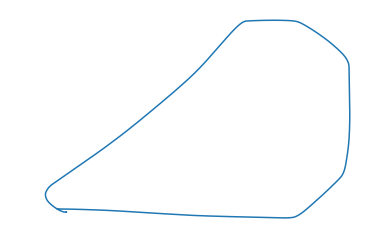

In [1]:
%matplotlib inline
import numpy as np
from numpy import sin, cos
from matplotlib import pyplot as plt
pos_init = np.zeros(shape=(2,1))
pos = pos_init
trajectory = pos

# Read ODOM
traj_file = open("../data/odom_polygon.txt", "r")
stream_ = traj_file.readlines()
stream_ = [x.strip() for x in stream_]

dt = 1/10

for i in range(1, len(stream_)):
    tokens_ = stream_[i].split(' ')
    # v, omega = float(tokens_[0]), float(tokens_[1])
    # pos = np.array([pos[0]+v*dt*cos(pos[2]), pos[1]+v*dt*sin(pos[2]), pos[2]+dt*omega]).reshape(-1, 1)
    pos = np.array([float(tokens_[0]), float(tokens_[1])]).reshape(2,1)
    trajectory = np.concatenate((trajectory, pos), axis=1)

# also consider doing scatter
plt.plot(trajectory[0,:], trajectory[1,:], )


## Convert the plot into an image, which we can then use for hough transform
plt.axis('off')
import io
from PIL import Image
buf = io.BytesIO()   # this alows us to "save" the image to memory!!
plt.savefig(buf, format='png')
buf.seek(0)
im = Image.open(buf)
im.show()  # shows you what the image looks like

# DO hough shit

In [22]:
import cv2
img = np.array(im)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
equ = cv2.bitwise_not(cv2.equalizeHist(gray))
#edges = cv2.Canny(equ,50,150,apertureSize = 3)
#img3 = Image.fromarray(equ)
#img3.show()

# distance resolution
d = 1  # distance resolution
# t = np.pi/18 # theta resolution
t = np.pi/10
thresh = 10
sdn = 1
stn = 1
lines = cv2.HoughLines(equ, d, t, thresh, sdn, stn)
for i in range(len(lines)):
    if i>8:
        break
    for rho,theta in lines[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
        
img_d = Image.fromarray(img)
img_d.show()
#cv2.imwrite('m1.jpg'.format(i),img)

In [16]:
max_rho = max(im.size)
n = len(lines)
intersections = []
for i in range(8):
    line1 = lines[i]
    rho1, theta1 = line1[0,0], line1[0,1]
    for j in range(8):
        line2 = lines[j]
        rho2, theta2 = line2[0,0], line2[0,1]
        theta = np.arctan((rho1 * np.cos(theta2) - rho2 * np.cos(theta1))/(rho2 * np.sin(theta1) - rho1 * np.sin(theta2)))
        if 0 <= theta <= np.pi/2:
            rho = rho1 / np.cos(theta - theta1)
            if 0 < rho <= max_rho:
                intersections.append((rho, theta, theta*180/np.pi))

/home/jayant/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in float_scalars
  # Remove the CWD from sys.path while we load stuff.


In [9]:
intersections.sort(key=lambda tup: tup[1])    # sort by theta, not sure if this is helpful
pts = []
for rho, theta, _ in intersections:
    x = int(rho * np.cos(theta))
    y = int(rho * np.sin(theta))
    pts.append((x,y))
    

In [10]:
from collections import defaultdict

In [27]:
condensed_pts = defaultdict(list)

for (x,y) in pts:
    new = True
    for (x2,y2),cluster in condensed_pts.items():
        dist = np.sqrt((x2-x) ** 2 + (y2-y) ** 2)
        # print(dist)
        if dist < 40:
            new = False
            break
    if new:
        condensed_pts[(x,y)] = [(x,y)]
    else:
        del(condensed_pts[(x2,y2)])
        cluster.append((x,y))
        new_center = tuple(np.array(cluster).mean(axis=0))
        condensed_pts[new_center] = cluster

final_pts = condensed_pts.keys()
print('Got {} points'.format(len(final_pts)))
for pt in final_pts:
    x, y = tuple(map(int, pt))
    cv2.circle(img, (x,y), 10, (255,0,0))
    
img_pts = Image.fromarray(img)
img_pts.show()


Got 8 points


In [26]:
img_pts.save('res.png')

# Experimental 1: Probablistic hough transform (note the "P" in  HOughLInesP)

In [20]:

import cv2
img = np.array(im)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
equ = cv2.bitwise_not(cv2.equalizeHist(gray))

minLineLength = 10
maxLineGap = 3
d = 2
t = np.pi/18
thresh = 10
n_keep = 25
lines = cv2.HoughLinesP(equ,d, t, thresh, minLineLength, maxLineGap)
for i in range(n_keep):
    # get line center points
    for x1,y1,x2,y2 in lines[i]:
        center = x1, y1
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2,)
img_d = Image.fromarray(img)
img_d.show()
cv2.imwrite('m2.jpg'.format(i),img)

True

# EXPERIMENTAL 2: Clustering in Hough space (Currently, using )
If I were you, I'd just ignore the rest of this notebook. Ask Q if you're interested.

In [152]:
import numpy as np
from matplotlib import cm
from sklearn import cluster
import psutil
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
h, theta, d = hough_line(equ)
h = np.uint16(h)
h = np.float64(cv2.resize(h,(180, 180), interpolation = cv2.INTER_CUBIC))
#d = np.linspace(-520, 520, 180)
#h = cv2.Laplacian(h,cv2.CV_64F)
rngs = range(180)

response = hough_line_peaks(hspace = h, angles =theta, dists=d)
print(response)

image = equ
ax = plt.gca()
ax.imshow(equ, cmap=cm.gray)
for i in response:
    print(i)
    angle = i[0]
    dist = i[1]
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax.plot((0, image.shape[1]), (y0, y1), '-r')
ax.set_xlim((0, image.shape[1]))
ax.set_ylim((image.shape[0], 0))
ax.set_axis_off()
ax.set_title('Detected lines')

# preform clustering on the thing.
#print(np.expand_dims(h, 0).shape)
#kmeans = cluster.KMeans(n_clusters=8, random_state=0).fit(np.expand_dims(h,0))
#kmeans
#h = cv2.equalizeHist(h)h = np.uint8(h)
h = np.uint8(h)
if h.shape[-1] !=3:
    h= cv2.cvtColor(h, cv2.COLOR_GRAY2RGB)
kernel = 0.5*np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
blur_kernel = 1*np.array([[1/16, 1/8, 1/16], 
                        [1/8, 1/4, 1/8],
                       [1/16, 1/8, 1/16]
                       ])
import time
sp = 10
sr = 10
for i in range(5):
    #h[h<25] = 0
    #dst = np.zeros(shape=(h.shape), dtype = np.float32)
    #h = cv2.normalize(h, dst, alpha=0, beta=1, norm_type=cv2.NORM_L1, dtype=cv2.CV_32F)
    #h = 255*h
    #h = h**1.01

SyntaxError: invalid syntax (<ipython-input-152-6dbc7aec37d5>, line 55)

(array([140., 139.]), array([-1.46549155,  0.83366286]), array([-464.94706449, -391.87680462]))
[140. 139.]
[-1.46549155  0.83366286]
[-464.94706449 -391.87680462]


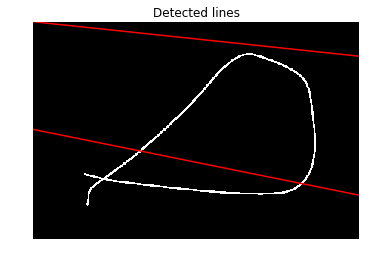

In [185]:
import numpy as np
from matplotlib import cm
from sklearn import cluster
import psutil

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
h, theta, d = hough_line(equ)
h = np.uint16(h)
h = np.float64(cv2.resize(h,(180, 180), interpolation = cv2.INTER_CUBIC))
#d = np.linspace(-520, 520, 180)
#h = cv2.Laplacian(h,cv2.CV_64F)
rngs = range(180)

response = hough_line_peaks(hspace = h, angles =theta, dists=d)
print(response)

image = equ
ax = plt.gca()
ax.imshow(equ, cmap=cm.gray)
for i in response:
    print(i)
    angle = i[0]
    dist = i[1]
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax.plot((0, image.shape[1]), (y0, y1), '-r')
ax.set_xlim((0, image.shape[1]))
ax.set_ylim((image.shape[0], 0))
ax.set_axis_off()
ax.set_title('Detected lines')

# preform clustering on the thing.
#print(np.expand_dims(h, 0).shape)
#kmeans = cluster.KMeans(n_clusters=8, random_state=0).fit(np.expand_dims(h,0))
#kmeans
#h = cv2.equalizeHist(h)h = np.uint8(h)
h = np.uint8(h)
if h.shape[-1] !=3:
    h= cv2.cvtColor(h, cv2.COLOR_GRAY2RGB)
kernel = 0.5*np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
blur_kernel = 1*np.array([[1/16, 1/8, 1/16], 
                        [1/8, 1/4, 1/8],
                       [1/16, 1/8, 1/16]
                       ])
import time
sp = 20
sr = 8
for i in range(20):
    
    cv2.imwrite('{:02}.jpg'.format(i),np.uint8(img_h))
    #h[h<25] = 0
    #dst = np.zeros(shape=(h.shape), dtype = np.float32)
    #h = cv2.normalize(h, dst, alpha=0, beta=1, norm_type=cv2.NORM_L1, dtype=cv2.CV_32F)
    #h = 255*h
    #h = h**1.01  
    h = cv2.filter2D(h, -1, blur_kernel)
    h = 255*(h/(np.max(h)))
    h[h>250] = 250
    h = np.uint8(h)
    kernel = np.array([[-1,-1,-1], [-1,4,-1], [-1,-1,-1]])
    for i in range(1):
        h[h>250] = 200
        h =  cv2.pyrMeanShiftFiltering(h, sp, sr)
        h[h<50]=0
    #h = cv2.filter2D(h, -1, kernel)
    
    h = cv2.filter2D(h, -1, kernel)
    img_h = Image.fromarray(h)
    time.sleep(0.5)  
    img_h.show()
    
for proc in psutil.process_iter():
    if proc.name() == "display":
        proc.kill()


In [153]:

# preform clustering on the thing.
#print(np.expand_dims(h, 0).shape)
#kmeans = cluster.KMeans(n_clusters=8, random_state=0).fit(np.expand_dims(h,0))
#kmeans
#h = cv2.equalizeHist(h)h = np.uint8(h)
h = np.uint8(h)
if h.shape[-1] !=3:
    h= cv2.cvtColor(h, cv2.COLOR_GRAY2RGB)
kernel = 0.5*np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
blur_kernel = np.array([[1/16, 1/8, 1/16], 
                        [1/8, 1/4, 1/8],
                       [1/16, 1/8, 1/16]
                       ])
import time
sp = 10
sr = 10
for i in range(10):
    #h[h<25] = 0
    #dst = np.zeros(shape=(h.shape), dtype = np.float32)
    #h = cv2.normalize(h, dst, alpha=0, beta=1, norm_type=cv2.NORM_L1, dtype=cv2.CV_32F)
    #h = 255*h
    h = np.uint8(h)
    #kernel = np.array([[-1,-1,-1], [-1,5,-1], [-1,-1,-1]])
    h =  cv2.pyrMeanShiftFiltering(h, sp, sr)
    #h[h<30]=0
    #h = cv2.filter2D(h, -1, blur_kernel)
    img_h = Image.fromarray(h)
    time.sleep(0.5)  
    img_h.show()
    
for proc in psutil.process_iter():
    if proc.name() == "display":
        proc.kill()


ValueError: too many values to unpack (expected 2)

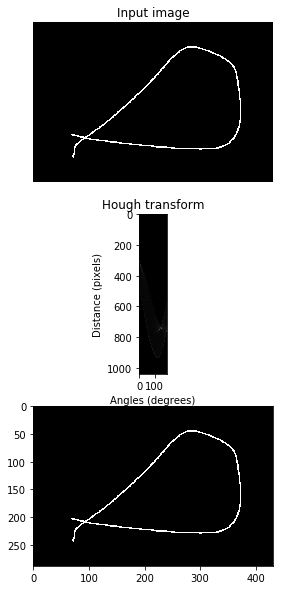

In [193]:
# Generating figure 1
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(equ, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

#ax[1].imshow(np.log(1 + h),
 #            extent=[theta[-1], theta[0], d[-1], d[0]],
  #           cmap=cm.gray, aspect=1/1.5)
ax[1].imshow(h)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

image = equ
ax[2].imshow(equ, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(hspace = h, angles = theta, dists=d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.show()

In [ ]:
for _, angle, dist in zip(*hough_line_peaks(hspace = h, angles = theta, dists=d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.show()

NameError: name 'image' is not defined

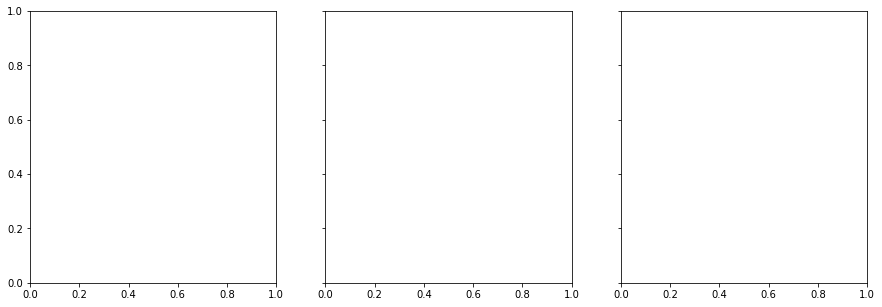

In [182]:


# Line finding using the Probabilistic Hough Transform
lines = probabilistic_hough_line(equ, threshold=10, line_length=5,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(equ, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(equ * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [1]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

NameError: name 'np' is not defined